<div style="display:block">
    <div style="width: 20%; display: inline-block; text-align: left;">
        <div class="crop">
            <img src="https://image4.owler.com/logo/rapido_owler_20190125_062402_original.png" style="height:75px; margin-left:0px" />
        </div>
    </div>
    <div style="width: 59%; display: inline-block">
            <h1  style="text-align: center">Mismatch Gradient Revamp</h1><br>
        <div style="width: 90%; text-align: center; display: inline-block;"><i>By:</i> <strong>Ritik Prakash</strong> </div>
    </div>
    <div style="width: 20%; text-align: right; display: inline-block;">
        <div style="width: 100%; text-align: left; display: inline-block;">
            <i>Created: </i>
            <time datetime="Enter Date" pubdate>6th April, 2023</time>
        </div>
    </div>
</div>

___
___

<div class="alert alert-block alert-danger">

# Configs
</div>

<div class="alert alert-block alert-warning">
    
### Enter Configs To Run The Notebook
Comment or Edit the changes in Similar Format
</div>

___

In [219]:
CITY = ('Hyderabad','Chennai','Kolkata', 'Delhi')
RUN_DATE = '20230418'
LOOK_BACK_PERIOD = 84
SERVICE = 'Link'

___

<div class="alert alert-block alert-info">

# Importing Packages
</div>

___

In [220]:
import pandas as pd
import numpy as np
import h3
from datetime import datetime
from pyhive import presto
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics.pairwise import cosine_similarity
from numpy import array, reshape
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Audio
sound_file = 'http://codeskulptor-demos.commondatastorage.googleapis.com/GalaxyInvaders/bonus.wav'
pd.options.mode.chained_assignment = None  # default='warn'

In [221]:
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)

In [222]:
conn = presto.connect(
            host='presto-gateway.serving.data.plectrum.dev',
            port=443,
            protocol='https',
            catalog='hive',
            username='ritik.prakash@rapido.bike')

___

<div class="alert alert-block alert-info">

# Download Data
</div>

___

In [223]:
mismatch_q = '''
        
        WITH mismatch_df AS (

                SELECT
                    city,
                    concat(substring(yyyymmdd,1,4),'-',substring(yyyymmdd,5,2),'-',substring(yyyymmdd,7,2)) as orderdate,
                    cluster,
                    substring(quarter_hour,1,2) AS hour,
                    quarter_hour,
                    SUM(rr_counts) AS rr_counts,
                    SUM(idle_captain_counts) AS idle_captain_counts,
                    SUM(mismatch_counts) AS mismatch
                FROM 
                (
                    SELECT
                        city,
                        a.hex_id AS hex_id,
                        yyyymmdd,
                        quarter_hour,
                        cluster,
                        rr_counts,
                        idle_captain_counts_probabilistic AS idle_captain_counts,
                        (rr_counts - idle_captain_counts_probabilistic) AS mismatch_counts
                    FROM 
                        datasets_internal.marketplace_mismatch_realtime_v2 a
                    INNER JOIN 
                        datasets.city_cluster_hex b 
                    ON a.hex_id = b.hex_id 
                    AND resolution=8
                    AND city IN {city}
                    WHERE
                        service_level = '{service}'
                        AND yyyymmdd >= date_format(date_add('day',-{look_back},date_parse('{run_date}','%Y%m%d')),'%Y%m%d')
                        AND yyyymmdd <= date_format(date_add('day',-1,date_parse('{run_date}','%Y%m%d')),'%Y%m%d')
                )
                WHERE 
                    cluster !=''
                GROUP BY 1,2,3,4,5
                ORDER BY 1,2,3,4,5
            )

        SELECT 
            city,
            orderdate,
            date_format(date_parse(orderdate,'%Y-%m-%d'),'%W') AS week_period,
            CASE 
                WHEN date_format(date_parse(orderdate,'%Y-%m-%d'),'%W') IN ('Monday','Friday') THEN 'Mon/Fri'
                WHEN date_format(date_parse(orderdate,'%Y-%m-%d'),'%W') IN ('Saturday','Sunday') THEN 'Sat/Sun'
                ELSE 'Tue/Wed/Thurs'
            END AS week_id,
            CASE 
                WHEN hour IN ('08','09','10','11') THEN 'morning_peak'
                WHEN hour IN ('12','13','14','15','16') THEN 'afternoon'
                WHEN hour IN ('17','18','19','20','21') THEN 'evening_peak'
                ELSE 'rest' 
            END AS time_period,
            hour,
            quarter_hour,
            cluster,
            rr_counts,
            idle_captain_counts,
            mismatch
        FROM 
            mismatch_df

        '''.format(
            city = CITY,
            service = SERVICE,
            look_back = LOOK_BACK_PERIOD,
            run_date = RUN_DATE)


In [224]:
orders_q = '''

        SELECT   
            city_name as city,
            date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
            date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%W') AS week_period,
            CASE 
                WHEN substring(quarter_hour,1,2) IN ('08','09','10','11') THEN 'morning_peak'
                WHEN substring(quarter_hour,1,2) IN ('12','13','14','15','16') THEN 'afternoon'
                WHEN substring(quarter_hour,1,2) IN ('17','18','19','20','21') THEN 'evening_peak'
                ELSE 'rest' 
            END AS time_period,
            substring(quarter_hour,1,2) AS hour,
            quarter_hour,
            cluster,
            COUNT(*) AS rr_count,
            SUM(CASE WHEN order_status = 'dropped' THEN 1 ELSE 0 END) AS net_count
        FROM
            orders.order_logs_snapshot a
        INNER JOIN 
            datasets.city_cluster_hex b 
        ON a.pickup_location_hex_8 = b.hex_id 
        AND resolution=8
        WHERE
            yyyymmdd >= date_format(date_add('day',-{look_back},date_parse('{run_date}','%Y%m%d')),'%Y%m%d')
            AND yyyymmdd <= date_format(date_add('day',-1,date_parse('{run_date}','%Y%m%d')),'%Y%m%d')
            AND service_obj_service_name = '{service}'
            AND city_name IN {city}
        GROUP BY 1,2,3,4,5,6,7
        ORDER BY 1,2,3,4,5,6,7

        '''.format(
            city = CITY,
            service = SERVICE,
            look_back = LOOK_BACK_PERIOD,
            run_date = RUN_DATE)

In [225]:
threshold_q = '''

        SELECT
            city,
            day_of_week AS week_period,
            mismatch_threshold,
            demand_threshold
        FROM
        (
        SELECT 
            city,
            yyyymmdd,
            day_of_week,
            MIN(mismatch_threshold) mismatch_threshold,
            MIN(demand_threshold) demand_threshold,
            RANK() OVER(ORDER BY yyyymmdd DESC) AS row_num
        FROM 
            hive.pricing_internal.iprice_mismatch_configs_immutable 
        WHERE 
            city IN {city} 
            AND service_level = lower('{service}')
        GROUP BY 1,2,3
        ORDER BY 1,2 DESC
        )
        WHERE row_num = 1
        ORDER BY 1 DESC
        
        '''.format(
            city = CITY,
            service = SERVICE)

In [461]:
city_clus = '''
        
        SELECT 
            DISTINCT 
            city,
            cluster 
        FROM 
            datasets.city_cluster_hex 
        WHERE 
            resolution=8 
            AND city IN {city}
            AND cluster != ''
        ORDER BY 1,2

        '''.format(
            city = CITY)
city_clus = pd.read_sql(city_clus, conn)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [228]:
mismatch_df = pd.read_sql(mismatch_q, conn)

In [229]:
order_df = pd.read_sql(orders_q, conn)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [512]:
mis_thresh = pd.read_sql(threshold_q, conn)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [231]:
mismatch_df.shape
mismatch_df.head()

(5047181, 11)

,city,orderdate,week_period,week_id,time_period,hour,quarter_hour,cluster,rr_counts,idle_captain_counts,mismatch
0,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,rest,00,0000,Adambakkam,1.0,2.0,-1.0
1,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,rest,00,0045,Adambakkam,0.0,4.0,-4.0
2,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,rest,05,0500,Adambakkam,0.0,3.0,-3.0
3,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,rest,05,0530,Adambakkam,0.0,2.0,-2.0
4,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,rest,06,0615,Adambakkam,1.0,2.0,-1.0


In [232]:
order_df.shape
order_df.head()

(5063188, 9)

,city,orderdate,week_period,time_period,hour,quarter_hour,cluster,rr_count,net_count
0,Chennai,2023-01-24,Tuesday,afternoon,12,1200,,5,2
1,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Adambakkam,8,2
2,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Adyar,14,9
3,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Alamathi,2,0
4,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Alandur,21,15


In [342]:
mis_thresh.shape
mis_thresh.head()

(28, 4)

,city,week_period,mismatch_threshold,demand_threshold
0,Kolkata,Sunday,3,3
1,Kolkata,Thursday,9,4
2,Kolkata,Monday,9,4
3,Kolkata,Friday,3,3
4,Kolkata,Tuesday,9,4


In [513]:
mis_thresh

,city,week_period,mismatch_threshold,demand_threshold
0,Kolkata,Friday,3,3
1,Kolkata,Tuesday,9,4
2,Kolkata,Wednesday,9,4
3,Kolkata,Monday,9,4
4,Kolkata,Saturday,3,3
5,Kolkata,Thursday,9,4
6,Kolkata,Sunday,3,3
7,Hyderabad,Saturday,25,20
8,Hyderabad,Wednesday,20,20
9,Hyderabad,Friday,20,20


In [511]:
mis_thresh

,city,week_period,mismatch_threshold,demand_threshold
0,Kolkata,Sunday,3,3
1,Kolkata,Thursday,9,4
2,Kolkata,Monday,9,4
3,Kolkata,Friday,3,3
4,Kolkata,Tuesday,9,4
5,Kolkata,Saturday,3,3
6,Kolkata,Wednesday,9,4
7,Hyderabad,Friday,20,20
8,Hyderabad,Thursday,20,20
9,Hyderabad,Sunday,20,20


In [462]:
city_clus.shape
city_clus.head()

(1057, 2)

,city,cluster
0,Chennai,Adambakkam
1,Chennai,Adyar
2,Chennai,Alamathi
3,Chennai,Alandur
4,Chennai,Allapakkam


___

<div class="alert alert-block alert-info">

# New Mismatch Gradient Logic
</div>

___

In [235]:
mismatch_data = mismatch_df.copy()

In [236]:
mismatch_data = pd.merge(mismatch_data,mis_thresh,on=['city','week_period'],how='left')

In [237]:
mismatch_data['mismatch_thresh'] = mismatch_data['mismatch']-mismatch_data['mismatch_threshold']

In [238]:
mismatch_pos = mismatch_data[mismatch_data['mismatch_thresh']>0].reset_index(drop=True)

In [239]:
mismatch_pos.shape
mismatch_pos.head()

(119730, 14)

,city,orderdate,week_period,week_id,time_period,hour,quarter_hour,cluster,rr_counts,idle_captain_counts,mismatch,mismatch_threshold,demand_threshold,mismatch_thresh
0,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,morning_peak,08,0845,Adambakkam,22.0,1.0,21.0,20,20,1.0
1,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,morning_peak,10,1000,Adambakkam,25.0,4.0,21.0,20,20,1.0
2,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,morning_peak,08,0845,Alandur,27.0,4.0,23.0,20,20,3.0
3,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,morning_peak,09,0915,Alandur,38.0,4.0,34.0,20,20,14.0
4,Chennai,2023-01-24,Tuesday,Tue/Wed/Thurs,morning_peak,09,0930,Alandur,34.0,5.0,29.0,20,20,9.0


In [240]:
def q20(x):
    return x.quantile(0.20)

def q30(x):
    return x.quantile(0.30)

def q40(x):
    return x.quantile(0.40)

def q50(x):
    return x.quantile(0.50)

def q60(x):
    return x.quantile(0.60)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.90)

In [241]:
mismatch_agg_thr = {'mismatch_thresh': ['size','nunique','min','max',q20, q40, q60, q75, q90]}

In [242]:
mismatch_stats = mismatch_pos.groupby(['city','cluster','week_period','time_period']).agg(mismatch_agg_thr)

In [243]:
mismatch_stats.head()

mismatch_thresh                \
                                                       size nunique   min   
city    cluster    week_period time_period                                  
Chennai Adambakkam Friday      morning_peak              27       9   1.0   
                   Monday      morning_peak              56      17   1.0   
                               rest                       1       1  13.0   
                   Thursday    morning_peak              28      12   1.0   
                   Tuesday     morning_peak              35       9   1.0   

                                                                           \
                                              max   q20   q40   q60   q75   
city    cluster    week_period time_period                                  
Chennai Adambakkam Friday      morning_peak  10.0   2.0   3.0   4.0   5.5   
                   Monday      morning_peak  22.0   4.0   6.0   8.0  11.0   
                               rest          13.0  13.0  13.0  13.0  13.0   
                   Thursday    morning_peak  16.0   1.4   2.0   4.2   7.5   
                   Tuesday     morning_peak  12.0   1.0   3.0   5.0   6.0   

                                                   
                                              q90  
city    cluster    week_period time_period         
Chennai Adambakkam Friday      morning_peak   6.4  
                   Monday      morning_peak  12.5  
                               rest          13.0  
                   Thursday    morning_peak  11.6  
                   Tuesday     morning_peak   7.0

In [244]:
mismatch_stats.columns = ['arr_len','unique_val','min','max','m_20_percentile','m_40_percentile','m_60_percentile',
                                 'm_75_percentile','m_90_percentile']

In [245]:
mismatch_stats = mismatch_stats.reset_index(level=1).reset_index()

In [246]:
mismatch_stats['m_20_percentile'] = mismatch_stats['m_20_percentile'].astype(int)
mismatch_stats['m_40_percentile'] = mismatch_stats['m_40_percentile'].astype(int)
mismatch_stats['m_60_percentile'] = mismatch_stats['m_60_percentile'].astype(int)
mismatch_stats['m_75_percentile'] = mismatch_stats['m_75_percentile'].astype(int)
mismatch_stats['m_90_percentile'] = mismatch_stats['m_90_percentile'].astype(int)

In [250]:
mismatch_stats.shape
mismatch_stats.head()

(7026, 13)

,city,week_period,time_period,cluster,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,Friday,morning_peak,Adambakkam,27,9,1.0,10.0,2,3,4,5,6
1,Chennai,Monday,morning_peak,Adambakkam,56,17,1.0,22.0,4,6,8,11,12
2,Chennai,Monday,rest,Adambakkam,1,1,13.0,13.0,13,13,13,13,13
3,Chennai,Thursday,morning_peak,Adambakkam,28,12,1.0,16.0,1,2,4,7,11
4,Chennai,Tuesday,morning_peak,Adambakkam,35,9,1.0,12.0,1,3,5,6,7


___

___

<div class="alert alert-block alert-danger">

# Analysing Minimun Gap Between Percentiles
</div>

___

In [251]:
mis_or = mismatch_df.copy()

In [252]:
mis_or = mis_or[['city', 'orderdate', 'week_period','time_period', 'hour','quarter_hour', 'cluster', 'mismatch']]

In [253]:
order_mis_df = pd.merge(order_df,mis_or,on=['city', 'orderdate', 'week_period','time_period', 'hour',
                                            'quarter_hour', 'cluster'],how = 'inner')

In [254]:
order_mis_df.head()

,city,orderdate,week_period,time_period,hour,quarter_hour,cluster,rr_count,net_count,mismatch
0,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Adambakkam,8,2,-2.0
1,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Adyar,14,9,-23.0
2,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Alandur,21,15,-8.0
3,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Allapakkam,4,3,-2.0
4,Chennai,2023-01-24,Tuesday,afternoon,12,1200,Alwarpet,6,4,-16.0


In [255]:
mismaatch_g2n = order_mis_df.groupby(['city','mismatch'])['rr_count','net_count'].sum().reset_index()

<ipython-input-255-0dc25c89ab86>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mismaatch_g2n = order_mis_df.groupby(['city','mismatch'])['rr_count','net_count'].sum().reset_index()


In [256]:
mismaatch_g2n['g2n'] = round(100*mismaatch_g2n['net_count']/mismaatch_g2n['rr_count'],2)

In [257]:
mismaatch_g2n

,city,mismatch,rr_count,net_count,g2n
0,Chennai,-69.0,28,18,64.29
1,Chennai,-66.0,63,43,68.25
2,Chennai,-65.0,35,29,82.86
3,Chennai,-64.0,23,21,91.30
4,Chennai,-63.0,42,29,69.05
...,...,...,...,...,...
2556,Kolkata,68.0,85,20,23.53
2557,Kolkata,69.0,75,20,26.67
2558,Kolkata,72.0,42,5,11.90
2559,Kolkata,73.0,75,18,24.00


In [258]:
mismaatch_g2n_sel = mismaatch_g2n[abs(mismaatch_g2n['mismatch'])<=50]

In [259]:
plt.rcParams["figure.figsize"] = (20,12)

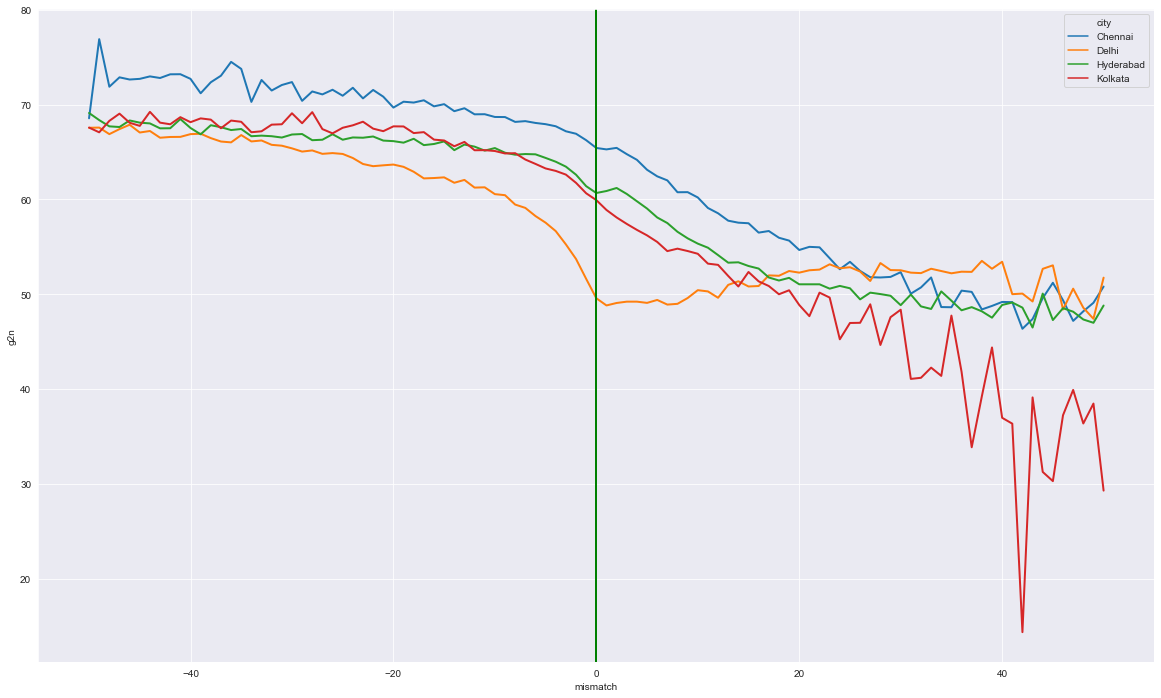

In [260]:
sns.set_style("darkgrid")
graph = sns.lineplot(x='mismatch',y='g2n',hue='city',data=mismaatch_g2n_sel,linewidth=2)
graph.axvline(0,linewidth=2, color='g')

In [261]:
mismaatch_g2n_sel[mismaatch_g2n_sel['mismatch']>0]

,city,mismatch,rr_count,net_count,g2n
68,Chennai,1.0,419221,273625,65.27
69,Chennai,2.0,358176,234337,65.43
70,Chennai,3.0,315931,204625,64.77
71,Chennai,4.0,278400,178657,64.17
72,Chennai,5.0,245750,155113,63.12
73,Chennai,6.0,217402,135722,62.43
74,Chennai,7.0,189698,117612,62.00
75,Chennai,8.0,173007,105110,60.75
76,Chennai,9.0,154666,93974,60.76
77,Chennai,10.0,136965,82451,60.20


___

In [262]:
g2n_diff_val = pd.DataFrame(columns =['city','mismatch_diff','g2n_diff'])

for city in mismaatch_g2n_sel['city'].unique():

    for x in range(1, 10):

        mis_df = mismaatch_g2n.copy()
        mismatch_list = list(range(-1, 20,x))
        mis_g2n_city = mis_df[mis_df['city']==city]
        mis_g2n_sel =  mis_g2n_city[mis_g2n_city['mismatch'].isin(mismatch_list)]
        mis_g2n_sel['prv_g2n'] = mis_g2n_sel['g2n'].shift(1)
        mis_g2n_sel = mis_g2n_sel.dropna()
        mis_g2n_sel['diff'] = mis_g2n_sel['prv_g2n']-mis_g2n_sel['g2n']
        mis_g2n_sel = mis_g2n_sel[(mis_g2n_sel['diff']>0)]
        avg_g2n_diff = round(mis_g2n_sel['diff'].mean(),2)

        row_to_append = pd.DataFrame([{'city':city, 'mismatch_diff':x, 'g2n_diff':avg_g2n_diff}])
        g2n_diff_val = pd.concat([g2n_diff_val,row_to_append])
    
g2n_diff_val = g2n_diff_val.reset_index(drop=True)

In [263]:
g2n_diff_val

,city,mismatch_diff,g2n_diff
0,Chennai,1,0.64
1,Chennai,2,1.06
2,Chennai,3,1.60
3,Chennai,4,2.12
4,Chennai,5,2.65
5,Chennai,6,3.19
6,Chennai,7,4.24
7,Chennai,8,4.38
8,Chennai,9,4.79
9,Delhi,1,0.60


___

___

In [264]:
min_diff_city = g2n_diff_val[g2n_diff_val['g2n_diff']<2].groupby('city')['mismatch_diff'].max().reset_index()

In [265]:
min_diff_city

,city,mismatch_diff
0,Chennai,3
1,Delhi,4
2,Hyderabad,4
3,Kolkata,3


___

In [266]:
sel_gradient = mismatch_stats.copy()

In [267]:
sel_gradient['min_max_diff'] = sel_gradient['max']-sel_gradient['min']

In [268]:
sel_gradient['diff1'] = sel_gradient['m_40_percentile']-sel_gradient['m_20_percentile']
sel_gradient['diff2'] = sel_gradient['m_60_percentile']-sel_gradient['m_40_percentile']
sel_gradient['diff3'] = sel_gradient['m_75_percentile']-sel_gradient['m_60_percentile']
sel_gradient['diff4'] = sel_gradient['m_90_percentile']-sel_gradient['m_75_percentile']

In [269]:
sel_gradient = pd.merge(sel_gradient,min_diff_city,on='city',how='left')

In [270]:
sel_gradient

,city,week_period,time_period,cluster,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile,min_max_diff,diff1,diff2,diff3,diff4,mismatch_diff
0,Chennai,Friday,morning_peak,Adambakkam,27,9,1.0,10.0,2,3,4,5,6,9.0,1,1,1,1,3
1,Chennai,Monday,morning_peak,Adambakkam,56,17,1.0,22.0,4,6,8,11,12,21.0,2,2,3,1,3
2,Chennai,Monday,rest,Adambakkam,1,1,13.0,13.0,13,13,13,13,13,0.0,0,0,0,0,3
3,Chennai,Thursday,morning_peak,Adambakkam,28,12,1.0,16.0,1,2,4,7,11,15.0,1,2,3,4,3
4,Chennai,Tuesday,morning_peak,Adambakkam,35,9,1.0,12.0,1,3,5,6,7,11.0,2,2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,Kolkata,Saturday,morning_peak,chakraborty para,4,4,3.0,9.0,4,6,6,7,8,6.0,2,0,1,1,3
7022,Kolkata,Sunday,evening_peak,chakraborty para,2,2,3.0,8.0,4,5,6,6,7,5.0,1,1,0,1,3
7023,Kolkata,Sunday,morning_peak,chakraborty para,1,1,6.0,6.0,6,6,6,6,6,0.0,0,0,0,0,3
7024,Kolkata,Sunday,evening_peak,telenipara,2,2,1.0,3.0,1,1,2,2,2,2.0,0,1,0,0,3


In [271]:
sel_gradient_diff = sel_gradient[(sel_gradient['diff1']>=sel_gradient['mismatch_diff'])&
                                 (sel_gradient['diff2']>=sel_gradient['mismatch_diff'])&
                                 (sel_gradient['diff3']>=sel_gradient['mismatch_diff'])&
                                 (sel_gradient['diff4']>=sel_gradient['mismatch_diff'])]

In [272]:
sel_gradient_diff = sel_gradient_diff.reset_index(drop=True)

In [273]:
sel_gradient_diff.shape
sel_gradient_diff.head()

(368, 19)

,city,week_period,time_period,cluster,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile,min_max_diff,diff1,diff2,diff3,diff4,mismatch_diff
0,Chennai,Friday,rest,Alandur,2,2,3.0,24.0,7,11,15,18,21,21.0,4,4,3,3,3
1,Chennai,Monday,morning_peak,Alandur,129,39,1.0,57.0,7,13,16,23,31,56.0,6,3,7,8,3
2,Chennai,Monday,rest,Alandur,143,30,1.0,38.0,5,9,13,17,23,37.0,4,4,4,6,3
3,Chennai,Wednesday,morning_peak,Alandur,68,23,1.0,31.0,3,6,9,14,20,30.0,3,3,5,6,3
4,Chennai,Monday,morning_peak,Anna Nagar,107,30,1.0,33.0,5,9,12,16,22,32.0,4,3,4,6,3


In [515]:
sel_gradient_diff1 = sel_gradient[(sel_gradient['diff1']>=2)&
                                 (sel_gradient['diff2']>=2)&
                                 (sel_gradient['diff3']>=2)&
                                 (sel_gradient['diff4']>=2)]

In [519]:
sel_gradient_diff1[sel_gradient_diff1['city']=='Kolkata']

,city,week_period,time_period,cluster,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile,min_max_diff,diff1,diff2,diff3,diff4,mismatch_diff
5016,Kolkata,Saturday,rest,Acropolis Mall Kasba,6,5,1.0,15.0,1,5,7,11,14,14.0,4,2,4,3,3
5115,Kolkata,Friday,rest,BBD Bagh,8,7,1.0,53.0,1,17,32,37,46,52.0,16,15,5,9,3
5120,Kolkata,Saturday,rest,BBD Bagh,2,2,28.0,47.0,31,35,39,42,45,19.0,4,4,3,3,3
5124,Kolkata,Thursday,rest,BBD Bagh,6,6,5.0,44.0,7,14,27,33,39,39.0,7,13,6,6,3
5181,Kolkata,Friday,afternoon,Ballygunge,91,17,1.0,20.0,2,4,7,9,13,19.0,2,3,2,4,3
5182,Kolkata,Friday,evening_peak,Ballygunge,126,19,1.0,26.0,3,5,7,10,13,25.0,2,2,3,3,3
5186,Kolkata,Monday,evening_peak,Ballygunge,80,19,1.0,23.0,2,4,6,10,13,22.0,2,2,4,3,3
5205,Kolkata,Wednesday,evening_peak,Ballygunge,65,17,1.0,20.0,2,4,7,10,13,19.0,2,3,3,3,3
5355,Kolkata,Friday,evening_peak,Beniapukur,19,10,1.0,17.0,1,3,6,8,10,16.0,2,3,2,2,3
5435,Kolkata,Friday,rest,Chandni Chowk M,8,6,1.0,17.0,1,3,6,12,15,16.0,2,3,6,3,3


___

___

<div class="alert alert-block alert-danger">

# Gradient Recommendation
</div>

___

___

In [274]:
gradient_rec = sel_gradient_diff.copy()

In [275]:
gradient_rec = pd.merge(gradient_rec,mis_thresh,on=['city','week_period'],how='left')

In [276]:
gradient_rec['m_20_percentile'] = gradient_rec['m_20_percentile']+gradient_rec['mismatch_threshold']
gradient_rec['m_40_percentile'] = gradient_rec['m_40_percentile']+gradient_rec['mismatch_threshold']
gradient_rec['m_60_percentile'] = gradient_rec['m_60_percentile']+gradient_rec['mismatch_threshold']
gradient_rec['m_75_percentile'] = gradient_rec['m_75_percentile']+gradient_rec['mismatch_threshold']
gradient_rec['m_90_percentile'] = gradient_rec['m_90_percentile']+gradient_rec['mismatch_threshold']

In [277]:
gradient_rec['thresh_diff'] = gradient_rec['m_20_percentile']-gradient_rec['mismatch_threshold']

In [278]:
gradient_rec = gradient_rec[gradient_rec['thresh_diff']>=gradient_rec['mismatch_diff']].reset_index(drop=True)

In [279]:
gradient_rec  = gradient_rec[['city','cluster','week_period', 'time_period',  'arr_len', 'unique_val', 'min',
       'max','min_max_diff', 'm_20_percentile', 'm_40_percentile', 'm_60_percentile',
       'm_75_percentile', 'm_90_percentile',  'diff1', 'diff2','diff3', 'diff4']]

In [280]:
gradient_rec = gradient_rec.sort_values(['city','cluster','week_period', 'time_period']).reset_index(drop=True)

In [281]:
gradient_rec.shape

(335, 18)

In [282]:
gradient_rec.groupby('city').size()

city
Chennai       71
Delhi        119
Hyderabad    124
Kolkata       21
dtype: int64

In [502]:
gradient_rec.shape
gradient_rec.head()

(335, 19)

,city,cluster,week_period,time_period,arr_len,unique_val,min,max,min_max_diff,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile,diff1,diff2,diff3,diff4,id
0,Chennai,Alandur,Friday,rest,2,2,3.0,24.0,21.0,27,31,35,38,41,4,4,3,3,Chennai_Alandur_rest_Friday
1,Chennai,Alandur,Monday,morning_peak,129,39,1.0,57.0,56.0,27,33,36,43,51,6,3,7,8,Chennai_Alandur_morning_peak_Monday
2,Chennai,Alandur,Monday,rest,143,30,1.0,38.0,37.0,25,29,33,37,43,4,4,4,6,Chennai_Alandur_rest_Monday
3,Chennai,Alandur,Wednesday,morning_peak,68,23,1.0,31.0,30.0,23,26,29,34,40,3,3,5,6,Chennai_Alandur_morning_peak_Wednesday
4,Chennai,Anna Nagar,Monday,morning_peak,107,30,1.0,33.0,32.0,25,29,32,36,42,4,3,4,6,Chennai_Anna Nagar_morning_peak_Monday


___

___

In [448]:
DAG_gradient_rec = gradient_rec[['city', 'cluster', 'week_period', 'time_period','m_20_percentile',
       'm_40_percentile', 'm_60_percentile', 'm_75_percentile','m_90_percentile']].reset_index(drop=True)

In [508]:
DAG_gradient_rec.head()

,city,cluster,week_period,time_period,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,Alandur,Friday,rest,27,31,35,38,41
1,Chennai,Alandur,Monday,morning_peak,27,33,36,43,51
2,Chennai,Alandur,Monday,rest,25,29,33,37,43
3,Chennai,Alandur,Wednesday,morning_peak,23,26,29,34,40
4,Chennai,Anna Nagar,Monday,morning_peak,25,29,32,36,42


In [514]:
DAG_gradient_rec

,city,cluster,week_period,time_period,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,Alandur,Friday,rest,27,31,35,38,41
1,Chennai,Alandur,Monday,morning_peak,27,33,36,43,51
2,Chennai,Alandur,Monday,rest,25,29,33,37,43
3,Chennai,Alandur,Wednesday,morning_peak,23,26,29,34,40
4,Chennai,Anna Nagar,Monday,morning_peak,25,29,32,36,42
5,Chennai,Arumbakkam 2,Monday,morning_peak,24,29,34,37,43
6,Chennai,Ashok Nagar Chennai,Monday,morning_peak,26,30,36,42,49
7,Chennai,Ashok Nagar Chennai,Thursday,morning_peak,25,28,32,35,39
8,Chennai,Ashok Nagar Chennai,Tuesday,morning_peak,23,26,29,32,36
9,Chennai,Ashok Nagar Chennai,Wednesday,morning_peak,24,27,30,34,40


In [509]:
DAG_gradient_rec.to_csv('DAG_gradient_rec.csv',index=False)

___

___

<div class="alert alert-block alert-danger">

# Default Gradient Recommendation
</div>

___

In [353]:
gradient_rec['id'] = gradient_rec['city']+'_'+gradient_rec['cluster']+'_'+gradient_rec[
    'time_period']+'_'+gradient_rec['week_period']

In [354]:
mismatch_pos['id'] = mismatch_pos['city']+'_'+mismatch_pos['cluster']+'_'+mismatch_pos[
    'time_period']+'_'+mismatch_pos['week_period']

In [355]:
not_rec_mis_df = mismatch_pos[mismatch_pos['id'].isin(gradient_rec['id'].unique())].reset_index(drop=True)

In [412]:
mismatch_agg_nr = {'mismatch_thresh': ['size','nunique','min','max',q20, q40, q60, q75, q90]}

In [413]:
mismatch_stats_nr = not_rec_mis_df.groupby(['city','week_period','time_period']).agg(mismatch_agg_thr)
mismatch_time_period = not_rec_mis_df.groupby(['city','time_period']).agg(mismatch_agg_thr)
mismatch_city = not_rec_mis_df.groupby(['city']).agg(mismatch_agg_thr)

In [414]:
mismatch_stats_nr.columns = ['arr_len','unique_val','min','max','m_20_percentile','m_40_percentile','m_60_percentile',
                                 'm_75_percentile','m_90_percentile']
mismatch_time_period.columns = ['arr_len','unique_val','min','max','m_20_percentile','m_40_percentile','m_60_percentile',
                                 'm_75_percentile','m_90_percentile']
mismatch_city.columns = ['arr_len','unique_val','min','max','m_20_percentile','m_40_percentile','m_60_percentile',
                                 'm_75_percentile','m_90_percentile']

In [419]:
mismatch_stats_nr = mismatch_stats_nr.reset_index(level=1).reset_index()
mismatch_time_period = mismatch_time_period.reset_index(level=1).reset_index()
mismatch_city = mismatch_city.reset_index()

In [420]:
mismatch_stats_nr['m_20_percentile'] = mismatch_stats_nr['m_20_percentile'].astype(int)
mismatch_stats_nr['m_40_percentile'] = mismatch_stats_nr['m_40_percentile'].astype(int)
mismatch_stats_nr['m_60_percentile'] = mismatch_stats_nr['m_60_percentile'].astype(int)
mismatch_stats_nr['m_75_percentile'] = mismatch_stats_nr['m_75_percentile'].astype(int)
mismatch_stats_nr['m_90_percentile'] = mismatch_stats_nr['m_90_percentile'].astype(int)

mismatch_time_period['m_20_percentile'] = mismatch_time_period['m_20_percentile'].astype(int)
mismatch_time_period['m_40_percentile'] = mismatch_time_period['m_40_percentile'].astype(int)
mismatch_time_period['m_60_percentile'] = mismatch_time_period['m_60_percentile'].astype(int)
mismatch_time_period['m_75_percentile'] = mismatch_time_period['m_75_percentile'].astype(int)
mismatch_time_period['m_90_percentile'] = mismatch_time_period['m_90_percentile'].astype(int)

mismatch_city['m_20_percentile'] = mismatch_city['m_20_percentile'].astype(int)
mismatch_city['m_40_percentile'] = mismatch_city['m_40_percentile'].astype(int)
mismatch_city['m_60_percentile'] = mismatch_city['m_60_percentile'].astype(int)
mismatch_city['m_75_percentile'] = mismatch_city['m_75_percentile'].astype(int)
mismatch_city['m_90_percentile'] = mismatch_city['m_90_percentile'].astype(int)

In [358]:
mismatch_stats_nr.head()

,city,time_period,week_period,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,afternoon,Friday,71,23,1.0,31.0,3,6,10,13,17
1,Chennai,evening_peak,Friday,461,52,1.0,63.0,5,9,14,19,30
2,Chennai,morning_peak,Friday,365,51,1.0,62.0,5,12,19,26,35
3,Chennai,rest,Friday,2,2,3.0,24.0,7,11,15,18,21
4,Chennai,afternoon,Monday,153,28,1.0,34.0,3,6,10,15,22


In [371]:
mismatch_time_period.head()

,city,time_period,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,afternoon,285,31,1.0,34.0,3,6,10,15,21
1,Chennai,evening_peak,2301,64,1.0,80.0,5,9,14,21,31
2,Chennai,morning_peak,3447,76,1.0,95.0,6,11,17,25,37
3,Chennai,rest,359,52,1.0,71.0,6,11,16,21,32
4,Delhi,afternoon,15,12,6.0,53.0,7,14,21,25,35


In [421]:
mismatch_city

,city,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,6392,79,1.0,95.0,5,10,16,22,34
1,Delhi,8031,113,1.0,163.0,7,14,24,33,47
2,Hyderabad,11337,247,1.0,288.0,7,15,23,33,55
3,Kolkata,1656,59,1.0,69.0,3,7,11,15,22


___

___

In [393]:
all_def_id = mismatch_pos.groupby(['city','week_period','time_period']).size().reset_index()

In [394]:
all_def_id = all_def_id[['city', 'week_period', 'time_period']]

In [423]:
all_def_id.head()

,city,week_period,time_period
0,Chennai,Friday,afternoon
1,Chennai,Friday,evening_peak
2,Chennai,Friday,morning_peak
3,Chennai,Friday,rest
4,Chennai,Monday,afternoon


___

## With Default Values

In [395]:
def_thresh = pd.merge(all_def_id,mismatch_stats_nr,on=['city', 'week_period', 'time_period'],how='left')

In [396]:
with_val_def_thresh = def_thresh[~def_thresh['m_20_percentile'].isna()]

In [430]:
with_val_def_thresh.head()

,city,week_period,time_period,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,Friday,afternoon,71.0,23.0,1.0,31.0,3.0,6.0,10.0,13.0,17.0
1,Chennai,Friday,evening_peak,461.0,52.0,1.0,63.0,5.0,9.0,14.0,19.0,30.0
2,Chennai,Friday,morning_peak,365.0,51.0,1.0,62.0,5.0,12.0,19.0,26.0,35.0
3,Chennai,Friday,rest,2.0,2.0,3.0,24.0,7.0,11.0,15.0,18.0,21.0
4,Chennai,Monday,afternoon,153.0,28.0,1.0,34.0,3.0,6.0,10.0,15.0,22.0


___

## Without Default Values

In [397]:
wo_val_def_thresh = def_thresh[def_thresh['m_20_percentile'].isna()]
wo_val_def_thresh = wo_val_def_thresh[['city','week_period','time_period']]

### Filling With City x Time Threshold

In [398]:
w_tp_values = pd.merge(wo_val_def_thresh,mismatch_time_period,on=['city','time_period'],how='left')

In [399]:
with_tp_values = w_tp_values[~w_tp_values['m_20_percentile'].isna()]

In [432]:
with_tp_values.head()

,city,week_period,time_period,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,Saturday,afternoon,285.0,31.0,1.0,34.0,3.0,6.0,10.0,15.0,21.0
1,Chennai,Saturday,rest,359.0,52.0,1.0,71.0,6.0,11.0,16.0,21.0,32.0
2,Chennai,Sunday,afternoon,285.0,31.0,1.0,34.0,3.0,6.0,10.0,15.0,21.0
3,Chennai,Sunday,evening_peak,2301.0,64.0,1.0,80.0,5.0,9.0,14.0,21.0,31.0
4,Chennai,Sunday,morning_peak,3447.0,76.0,1.0,95.0,6.0,11.0,17.0,25.0,37.0


### Filling With City Only Threshold

In [400]:
wo_any_values = w_tp_values[w_tp_values['m_20_percentile'].isna()]

In [425]:
wo_any_values = wo_any_values[['city','week_period','time_period']]

In [426]:
with_city_values = pd.merge(wo_any_values,mismatch_city,on=['city'],how='left')

In [428]:
with_city_values.head()

,city,week_period,time_period,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Kolkata,Friday,afternoon,1656,59,1.0,69.0,3,7,11,15,22
1,Kolkata,Monday,afternoon,1656,59,1.0,69.0,3,7,11,15,22
2,Kolkata,Saturday,afternoon,1656,59,1.0,69.0,3,7,11,15,22
3,Kolkata,Sunday,afternoon,1656,59,1.0,69.0,3,7,11,15,22
4,Kolkata,Thursday,afternoon,1656,59,1.0,69.0,3,7,11,15,22


___

___

In [435]:
default_all_rec = pd.concat([with_val_def_thresh,with_tp_values,with_city_values])
default_all_rec = default_all_rec.sort_values(['city','week_period','time_period']).reset_index(drop=True)

In [441]:
default_all_rec.shape[0] == all_def_id.shape[0]

True

In [442]:
default_all_rec = pd.merge(default_all_rec,mis_thresh,on=['city','week_period'],how='left')

In [444]:
default_all_rec['m_20_percentile'] = default_all_rec['m_20_percentile']+default_all_rec['mismatch_threshold']
default_all_rec['m_40_percentile'] = default_all_rec['m_40_percentile']+default_all_rec['mismatch_threshold']
default_all_rec['m_60_percentile'] = default_all_rec['m_60_percentile']+default_all_rec['mismatch_threshold']
default_all_rec['m_75_percentile'] = default_all_rec['m_75_percentile']+default_all_rec['mismatch_threshold']
default_all_rec['m_90_percentile'] = default_all_rec['m_90_percentile']+default_all_rec['mismatch_threshold']

In [445]:
default_all_rec.head()

,city,week_period,time_period,arr_len,unique_val,min,max,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile,mismatch_threshold,demand_threshold
0,Chennai,Friday,afternoon,71.0,23.0,1.0,31.0,23.0,26.0,30.0,33.0,37.0,20,20
1,Chennai,Friday,evening_peak,461.0,52.0,1.0,63.0,25.0,29.0,34.0,39.0,50.0,20,20
2,Chennai,Friday,morning_peak,365.0,51.0,1.0,62.0,25.0,32.0,39.0,46.0,55.0,20,20
3,Chennai,Friday,rest,2.0,2.0,3.0,24.0,27.0,31.0,35.0,38.0,41.0,20,20
4,Chennai,Monday,afternoon,153.0,28.0,1.0,34.0,23.0,26.0,30.0,35.0,42.0,20,20


In [450]:
DEFAULT_gradient_rec = default_all_rec[['city', 'week_period', 'time_period','m_20_percentile',
       'm_40_percentile', 'm_60_percentile', 'm_75_percentile','m_90_percentile']].reset_index(drop=True)

In [451]:
DEFAULT_gradient_rec.head()

,city,week_period,time_period,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,Friday,afternoon,23.0,26.0,30.0,33.0,37.0
1,Chennai,Friday,evening_peak,25.0,29.0,34.0,39.0,50.0
2,Chennai,Friday,morning_peak,25.0,32.0,39.0,46.0,55.0
3,Chennai,Friday,rest,27.0,31.0,35.0,38.0,41.0
4,Chennai,Monday,afternoon,23.0,26.0,30.0,35.0,42.0


In [510]:
DEFAULT_gradient_rec.to_csv('DEFAULT_gradient_rec.csv',index=False)

___

___

<div class="alert alert-block alert-danger">

# Building Recommendation
</div>

___

In [482]:
recomendation_all_pos = pd.merge(city_clus,all_def_id,on='city',how='left')

In [483]:
recomendation_all_pos = pd.merge(recomendation_all_pos,DAG_gradient_rec,on=[
    'city', 'cluster', 'week_period', 'time_period',],how='left')

In [485]:
recomendation_all_pos_DAG = recomendation_all_pos[~recomendation_all_pos['m_20_percentile'].isna()]

In [486]:
recomendation_all_pos_DEFAULT = recomendation_all_pos[recomendation_all_pos['m_20_percentile'].isna()]

In [493]:
recomendation_all_pos_DEFAULT = recomendation_all_pos_DEFAULT[['city', 'cluster', 'week_period', 'time_period']]

In [494]:
recomendation_all_pos_DEFAULT = pd.merge(recomendation_all_pos_DEFAULT,DEFAULT_gradient_rec,on=[
    'city', 'week_period', 'time_period',],how='left')

___

___

___

In [505]:
recommendation_FINAL = pd.concat([recomendation_all_pos_DAG,recomendation_all_pos_DEFAULT])
recommendation_FINAL = recommendation_FINAL.sort_values(['city','cluster','week_period','time_period'])
recommendation_FINAL = recommendation_FINAL.reset_index(drop=True)

In [506]:
recommendation_FINAL

,city,cluster,week_period,time_period,m_20_percentile,m_40_percentile,m_60_percentile,m_75_percentile,m_90_percentile
0,Chennai,Adambakkam,Friday,afternoon,23.0,26.0,30.0,33.0,37.0
1,Chennai,Adambakkam,Friday,evening_peak,25.0,29.0,34.0,39.0,50.0
2,Chennai,Adambakkam,Friday,morning_peak,25.0,32.0,39.0,46.0,55.0
3,Chennai,Adambakkam,Friday,rest,27.0,31.0,35.0,38.0,41.0
4,Chennai,Adambakkam,Monday,afternoon,23.0,26.0,30.0,35.0,42.0
...,...,...,...,...,...,...,...,...,...
29591,Kolkata,uttarPara H,Tuesday,rest,13.0,17.0,36.0,47.0,58.0
29592,Kolkata,uttarPara H,Wednesday,afternoon,12.0,16.0,20.0,24.0,31.0
29593,Kolkata,uttarPara H,Wednesday,evening_peak,13.0,16.0,19.0,23.0,29.0
29594,Kolkata,uttarPara H,Wednesday,morning_peak,12.0,15.0,18.0,21.0,27.0


In [500]:
rec_name =  'Mismatch_Gradient_Recommendation_'+RUN_DATE+'_'+SERVICE+'.csv'
recommendation_FINAL.to_csv(rec_name,index=False)

___

___

___

___

___